# Model 1 - Logistic Regression

The most basic learning algorithm, perfect for binary classification. My primary goal in this investigation is to figure out a good workflow for training, evaluating, and testing shallow learning models. 

A lot of this work will therefore be experimental.

## Preparing Workspace

In [0]:
# Standard imports
import numpy as np
import pandas as pd

# Seed random number generator for consistent OPs across runs
np.random.seed(42)

# Matplotlib styles
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')

# Seaborn for distributions
from seaborn import distplot

# No warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit imports
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, aver 
from seaborn import light_palette

## Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os

!ls '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/'

'AB Notes'	   'FYP Report Guidelines.gdoc'     'Progress Reports'
 Assignments	   'Ignite NGIRI Fund Application'   Proposals
 Data		   'Literature Review Papers'
'DL Roadmap.gdoc'   Meetings


In [4]:
fyp_dir = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection'
data_dir = 'Data'
data_file = 'data-final.csv'
data_path = os.path.join(fyp_dir, data_dir, data_file)
print(data_path)

/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/data-final.csv


In [0]:
data = pd.read_csv(data_path)

In [6]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.76,6.15,6.50,8.08,7.97,8.81,7.37,11.72,11.02,8.18,7.33,6.71,8.52,6.31,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,16.68,16.28,13.96,16.13,12.73,14.03,14.42,15.73,16.71,14.27,14.17,17.73,17.67,20.40,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.77,13.03,12.26,15.66,13.43,15.03,14.61,13.97,15.07,14.11,14.77,11.72,11.73,11.98,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.15,9.16,10.19,10.31,8.03,10.08,10.34,11.24,15.14,14.36,12.39,10.36,9.29,7.91,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


## Extracting Features and Targets

In [0]:
# Targets - class labels for all training samples
y = data['FLAG'].values

In [0]:
X = data.iloc[:, 2:].values

In [0]:
# Is there one training sample per label?
assert X.shape[0] == y.shape[0]

## Stratified Sampling 

The dataset has a very large class imbalance - an approximate ~91/9 split between the negative (regular, non-target) and positive (thief, target) classes. 

As such, the model must not only be trained on a subset of the original data with this 91-9 split, but must also be validated for similarly proportioned data.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Test Size = 1 - Training Ratio
TEST_SIZE = 0.20

In [0]:
# Shuffling data and making sure both training and test sets contain same proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=y)

### Visualizing Distributions of Classes

In [0]:
import seaborn as sns

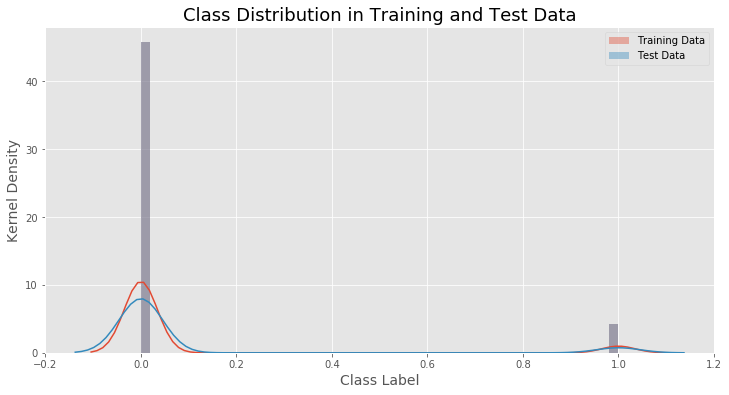

In [0]:
plt.figure(figsize=(12, 6))
sns.distplot(y_train)
sns.distplot(y_test)
plt.legend(['Training Data', 'Test Data'])
plt.xlabel('Class Label', fontsize=14)
plt.ylabel('Kernel Density', fontsize=14)
plt.title('Class Distribution in Training and Test Data', fontsize=18);

### Interpretation

This isn't a great plot. 
- For starters, we're not interested in class labels other than 0.0 and 1.0, but the `distplot` command treats class label as a continuous random variable.
- The histograms also overlap, which means its difficult to see whether the bars representing Training Data's class distribution is lower than or equal to that of Test Data.
- Thirdly, it isn't readily interpretable. I have no idea what Kernel Density is. 

### Making Bar Graphs of Class Label Counts

In [0]:
# Dictionaries of raw counts of class labels
raw_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0),
        '1': np.count_nonzero(y_train == 1)
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0),
        '1': np.count_nonzero(y_test == 1)
    }
}

In [0]:
# Repeat for normalized counts
NUM_TRAIN = len(y_train)
NUM_TEST = len(y_test)
NUM_SAMPLES = len(y)

normed_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0) / NUM_TRAIN,
        '1': np.count_nonzero(y_train == 1) / NUM_TRAIN
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0) / NUM_TEST,
        '1': np.count_nonzero(y_test == 1) / NUM_TEST
    }
}

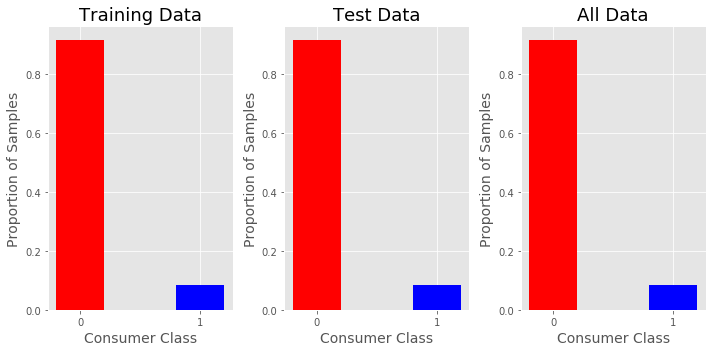

In [0]:
# Comparing train, test, and original data in 3 side-by-side graphs
fig, axes = plt.subplots(ncols=3, figsize=(10, 5), sharey=False)

# First plot - Training Data
plt.sca(axes[0])
plt.bar(x=normed_counts['train'].keys(), height=normed_counts['train'].values(), 
       color=['red', 'blue'], width=0.4)
plt.xlabel('Consumer Class', fontsize=14)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Training Data', fontsize=18)

# Second plot - Test Data
plt.sca(axes[1])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), height=normed_counts['test'].values(), 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Test Data', fontsize=18)


# Third plot - All data
plt.sca(axes[2])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), 
       height=[np.count_nonzero(y == 0) / NUM_SAMPLES, 
               np.count_nonzero(y == 1) / NUM_SAMPLES], 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('All Data', fontsize=18)
plt.tight_layout()

Have confirmed that the `stratify` argument in `train_test_split` has worked as expected: there are equal proportions of both the positive and negative classes in both the training and test data.

Furthermore, these proportions are exactly the same as in the entire dataset prior to the train/test split.

## First Model

### Training

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
logReg_1 = LogisticRegression()

In [0]:
logReg_1.fit(X_train, y_train)

/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
# Did it learn one parameter for each day?
print("Number of parameters learnt: ", len(logReg_1.coef_[0]))

Number of parameters learnt:  1034


### Evaluation

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [0]:
y_pred = logReg_1.predict(X_test)

In [0]:
confusion_matrix(y_test, y_pred)

array([[9304,  385],
       [ 792,  112]])

In [0]:
print(classification_report(y_test, y_pred, target_names=['Regular', 'Thieves']))

              precision    recall  f1-score   support

     Regular       0.92      0.96      0.94      9689
     Thieves       0.23      0.12      0.16       904

   micro avg       0.89      0.89      0.89     10593
   macro avg       0.57      0.54      0.55     10593
weighted avg       0.86      0.89      0.87     10593



In [0]:
roc_auc_score(y_test, y_pred)

0.5420790112316037

In [0]:
precision, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=1)

In [0]:
len(precision)

3

In [0]:
len(recall)

3

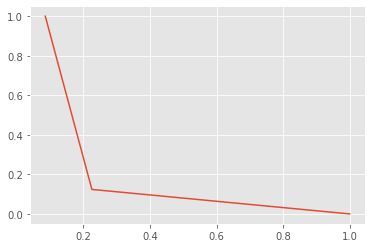

In [0]:
plt.plot(precision, recall)

In [0]:
from tensorflow.compat.v1.metrics import average_precision_at_k

In [0]:
# Number of samples used for mean average precision
K1 = 100
K2 = 200

In [0]:
# Confirming both pred and test have enough labels for MAP computation
assert len(y_test) >= np.max([K1, K2])
assert len(y_pred) >= np.max([K1, K2])

In [0]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [0]:
# Disabling Eager Execution for MAP
tf.compat.v1.disable_eager_execution()

In [0]:
_, m_ap_LR_100 = average_precision_at_k(y_test, y_pred, k=K1)

## Starting Over

In [0]:
def get_classification_result(y_pred, y_true, classifier_name=None):
    """Custom function to display classification results"""
    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves']))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    conf_mat = pd.DataFrame(data=confusion_matrix(y_true, y_pred))
    conf_mat.index = ['True 0', 'True 1']
    conf_mat.columns = ['Predicted 0', 'Predicted 1']
    cm = light_palette('blue', as_cmap=True)
    conf_mat_display = conf_mat.style.background_gradient(cmap=cm)
    display(conf_mat_display)
    
    # Display ROC 
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr) 
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right')
    
    if classifier_name is not None:
        plt.title(f'ROC Curve - {classifier_name}', fontsize=14)

In [0]:
# Creating a Data Pipeline
from sklearn.pipeline import Pipeline

# For transformer class
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.base import BaseEstimator, TransformerMixin

In [0]:
# Creating a custom transformer 
class MyFeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scalingStrategy='StandardScaler'):
        """Initialize this transformer with an instance of the scaler you wish to use"""
        # Initialise dictionary of all possible scaling strategies
        self.scalingStrategies = {
            'StandardScaler': StandardScaler(),
            'MinMaxScaler': MinMaxScaler(),
            'MaxAbsScaler': MaxAbsScaler(),
            'RobustScaler': RobustScaler(),
            'ScaleByConsumer': Normalizer(),
        }
        self.scaler = self.scalingStrategies[scalingStrategy]
        
    def fit(self, X, y=None):
        # Do nothing for now
        return self.scaler.fit(X, y)
    
    def transform(self, X, y=None):
        scaled_features = self.scaler.transform(X, y)

In [0]:
pipeline = Pipeline([
    ('featureScaler', MyFeatureScaler())
])

In [0]:
scaledFeatures = pipeline.fit_transform(X_train, y_train)

Text(0, 0.5, 'Maximum Feature Value (Post Standard Scaling)')

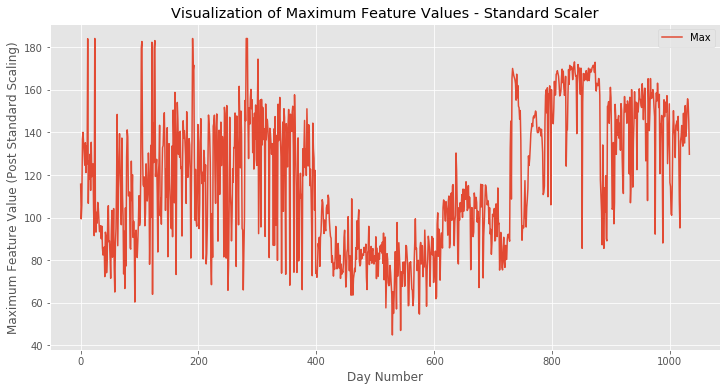

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(scaledFeatures).max(), label='Max')
plt.legend()
plt.title('Visualization of Maximum Feature Values - Standard Scaler')
plt.xlabel('Day Number')
plt.ylabel('Maximum Feature Value (Post Standard Scaling)')

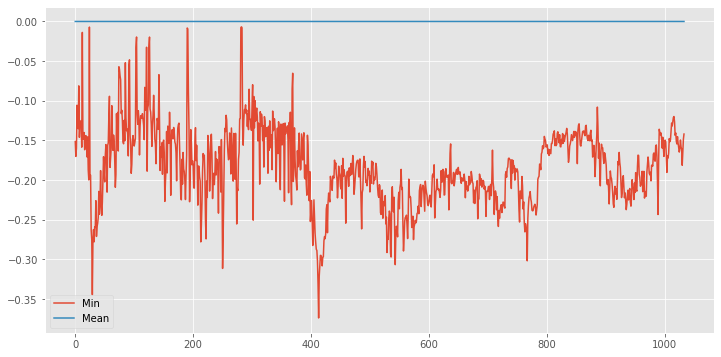

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(scaledFeatures).min(), label='Min')
plt.plot(pd.DataFrame(scaledFeatures).mean(), label='Mean')
plt.legend()

Minimum and mean values look fine. But maximum values do not. Is this a consequence of outliers being identified by consumer and not by day?

In [0]:
scaledByConsumer = Pipeline([
    ('featureScaler', MyFeatureScaler('ScaleByConsumer'))
]).fit_transform(X_train, y_train)

In [0]:
def visualize_feature_distribution(features, titleStr, sameGraph=False, withSNS=False):
    plt.tight_layout() 
    
    if withSNS:
        plt.figure(figsize=(10, 6))
        distplot(features.ravel(), kde=False) # KDE takes a LOOOOOONG TIME
        plt.xlabel('Feature Value', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(str('Distribution of Feature Values: ' + titleStr), fontsize=18)
        
    else:
        data = pd.DataFrame(features)
        if sameGraph:
            title = 'Feature Distribution: ' + titleStr
            plt.figure(figsize=(12, 6))
            plt.plot(data.max(), label='Max')
            plt.plot(data.min(), label='Min')
            plt.plot(data.mean(), label='Mean')
            plt.fill_between(data.mean() + data.std(), data.mean() - data.std())

            plt.legend(loc='lower right')
            plt.xlabel('Day Number', fontsize=14)
            plt.ylabel('Feature Values', fontsize=14)
            plt.title(title, fontsize=18)

        else: 
            title_1 = 'Maximum Feature Values: ' + titleStr
            title_2 = 'Minimum/Mean Feature Values: ' + titleStr

            plt.subplot(121)
            plt.plot(pd.DataFrame(features).max(), label='Maximum')
            plt.xlabel('Day Number', fontsize=14)
            plt.ylabel('Feature Values', fontsize=14)
            plt.title(title_1, fontsize=18)

            plt.subplot(122)
            plt.plot(pd.DataFrame(features).min(), label='Minimum')
            plt.plot(pd.DataFrame(features).mean(), label='Mean')
            plt.xlabel('Day Number', fontsize=14)
            plt.ylabel('Feature Values', fontsize=14)
            plt.title(title_2, fontsize=18)

<Figure size 432x288 with 0 Axes>

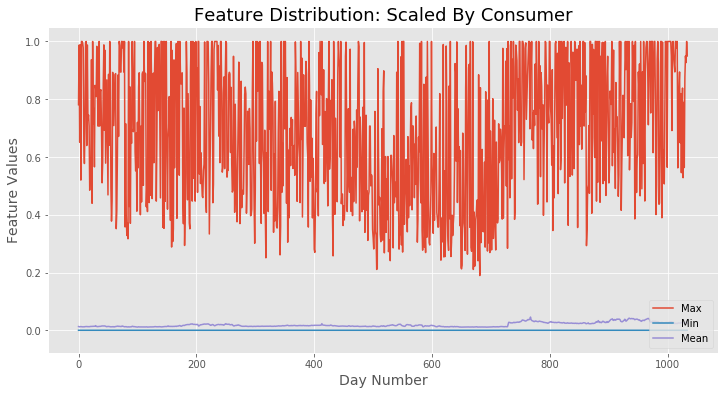

In [0]:
visualize_feature_distribution(scaledByConsumer, titleStr='Scaled By Consumer', sameGraph=True)

This looks good. No feature value exceeds 1.0 when scaled on a consumer basis.

<Figure size 432x288 with 0 Axes>

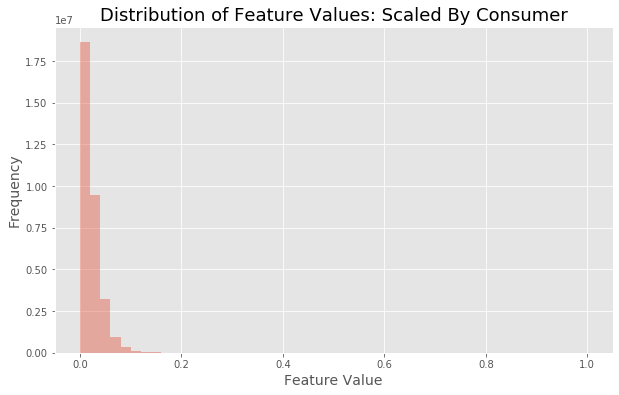

In [0]:
visualize_feature_distribution(scaledByConsumer, 'Scaled By Consumer', withSNS=True)

This looks alarming. Why are majority of the features near zero? Why isn't this distribution more Gaussian? Why is it so skewed? 
- Maybe because on most days, users will tend to use closeer to the minimum kWh rather than the maximum kWh?
- Also because the preprocessing has replaced a lot of feature values with 0 in case of missing values. Is this a sparse matrix?

In [0]:
from seaborn import heatmap

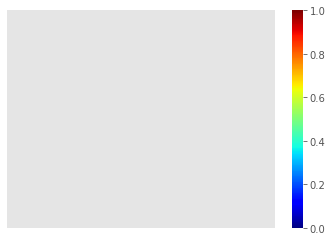

In [0]:
heatmap(scaledByConsumer, cmap='jet', xticklabels=False, yticklabels=False)

I give up. I'm just going to train a model.

## First Logistic Regression Model

In [0]:
from sklearn.linear_model import LogisticRegressionCV

In [0]:
# Using default parameters for now
logRegCV = LogisticRegressionCV()

In [23]:
logRegCV.fit(scaledByConsumer, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
probas = logRegCV.predict_proba(X_test)
y_pred = logRegCV.predict(X_test)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.96      0.23      0.37      7752
         Thieves       0.10      0.90      0.18       723

        accuracy                           0.28      8475
       macro avg       0.53      0.57      0.27      8475
    weighted avg       0.89      0.28      0.35      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,1748,6004
True 1,69,654


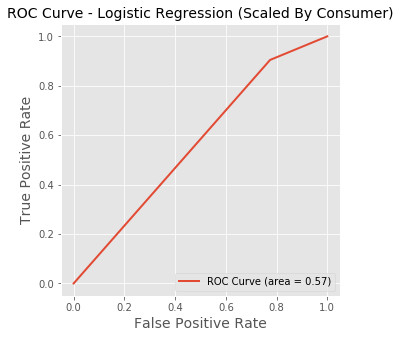

In [25]:
get_classification_result(y_pred, y_test, classifier_name='Logistic Regression (Scaled By Consumer)')

### Interpretation
- Confusion matrix shows us 
    - **High true negative**: it is very good at identifying regular consumers correctly.
    - **Exceedingly high false positive rate**: it will often label regular consumers as thieves.
    - **Very low false negative**: will rarely mislabel thieves as regular consumers.
    - **Moderately high true positive**: will often identify thieves correctly.
- Classification Report shows us
    - **Poor F1 score for both regular consumer and thieves.**
    - It is surprising that the F1 score for negative class is only twice that of the positive class, even though there exists a 91-9 imbalance between the two.
- Area under the curve is 0.57
    - This is a 7% raw increase, and a 14% relative increase compared to the ROC Curve Area of the baseline classifier.


### TLDR: Untuned logreg model does not do very well when compared to a classifier that always predicts 0.

## Hyperparameter Tuning

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer

In [0]:
param_grid = {
    'C': np.logspace(-3, 3, 5),     # Regularization coefficient - lower values = stronger regularization
    'penalty': ['l1', 'l2'],        # L1 norm or L2 norm for regularization
    'fit_intercept': [True, False], # Include bias term or not
}

In [0]:
# Instantiate a Logistic Regression Model
logReg = LogisticRegression(random_state=0)

In [0]:
# Instantiate a grid search object with defined params
# Also using area under cuvre as metric for identifying best model
logReg_CV = GridSearchCV(logReg,                 # Optimising Logistic Regression model
                         param_grid,             # Based on the params specified
                                                 # Using K-Fold CV with 5 splits
                         cv=StratifiedKFold(n_splits=5, random_state=0), 
                         verbose=1,              # Print at least some messages to console
                         n_jobs=-1,              # Use all available scores
                         # Use area under curve as metric to identify best model
                         scoring=make_scorer(roc_auc_scorer, greater_is_better=True))

In [30]:
logReg_CV.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, ret

In [0]:
# Saving the model
import pickle 

In [0]:
filename = 'logRegCV_1.sav'
pickle.dump(logReg_CV, open(filename, 'wb'))

In [39]:
logReg_CV.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
logReg_CV.best_score_

0.5740481510365865

In [0]:
logRegCVResults = pd.DataFrame(logReg_CV.cv_results_)

In [0]:
logRegCVResults.sort_values(by=['rank_test_score'], ascending=True, inplace=True)

In [0]:
visualizeCVResults(logReg_CV, metric='auc', model_name='LogReg (Normalized Consumers)')

## Interpretation
Hyperparameter tuning did not do much to improve the model's area under curve. It is still 57.4%, even though Zheng says a training ratio of 80-20 should give an AuC of ~67% for an `L2` penalty with inverse regularization strength of 1.0.

In [0]:
from tensorflow.compat.v1.metrics import average_precision_at_k
from sklearn.metrics import average_precision_score

In [0]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(random_state=0)

In [0]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
avg_precision_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

In [0]:
# Instantiating a grid search object that will use both AUC and MAP 
logReg_CV_2 = GridSearchCV(
    logReg,     
    param_grid, 
    cv=StratifiedKFold(n_splits=5, random_state=0),
    verbose=1,
    n_jobs=-1,
    scoring = {
        'roc_auc_scorer': roc_auc_scorer,
        'map_scorer': avg_precision_scorer,
    }, 
    refit='roc_auc_scorer',
)

In [198]:
logReg_CV_2.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n...
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit='roc_auc_scorer

In [199]:
pd.DataFrame(logReg_CV_2.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_fit_intercept', 'param_penalty', 'params',
       'split0_test_roc_auc_scorer', 'split1_test_roc_auc_scorer',
       'split2_test_roc_auc_scorer', 'split3_test_roc_auc_scorer',
       'split4_test_roc_auc_scorer', 'mean_test_roc_auc_scorer',
       'std_test_roc_auc_scorer', 'rank_test_roc_auc_scorer',
       'split0_test_map_scorer', 'split1_test_map_scorer',
       'split2_test_map_scorer', 'split3_test_map_scorer',
       'split4_test_map_scorer', 'mean_test_map_scorer', 'std_test_map_scorer',
       'rank_test_map_scorer'],
      dtype='object')

In [0]:
def visualizeCVResults(cv_obj, model_name=None, metric='auc'):
  # First, convert to dataframe
  cvResults = pd.DataFrame(cv_obj.cv_results_)
  if metric=='auc':
      # Drop unnecessary columns
      newResults = cvResults[['rank_test_roc_auc_scorer', 'params', 'mean_test_roc_auc_scorer',
                           'std_test_roc_auc_scorer']]
  
      # Then, sort by rank - highest score comes first
      newResults.sort_values(by=['rank_test_roc_auc_scorer'], inplace=True, ascending=True)
  else:
      newResults = cvResults[['rank_test_map_scorer', 'params', 'mean_test_map_scorer', 
                             'std_test_map_scorer']]
      # Then, sort by rank - highest score comes first
      newResults.sort_values(by=['rank_test_map_scorer'], inplace=True, ascending=True)

  # Rename the columns for easier referencing, regardless of metrics
  newResults.columns = ['rank_test_score', 'params', 'mean_test_score', 'std_test_score']

  # Create a bar graph

  # Make a figure
  plt.figure(figsize=(12, 6))

  # One bar for each model being compared, so one tick for each bar
  xtick_range = list(range(0, len(newResults)))

  # Label for the ticks will be the parameters
  xtick_labels = newResults['params']

  # Plot the bar graph
  plt.bar(xtick_range, height=newResults['mean_test_score'])

  # Replace the tick labels with parameter values
  plt.xticks(xtick_range, xtick_labels, rotation='vertical')

  # Annotate
  plt.xlabel('Parameters', fontsize=14)
  y_label_str = 'Mean CV AUC' if metric is 'auc' else 'Mean CV AP'
  plt.ylabel(y_label_str, fontsize=14)
  title_str = y_label_str + ' - '  + model_name if model_name is not None else y_label
  plt.title(title_str, fontsize=18)

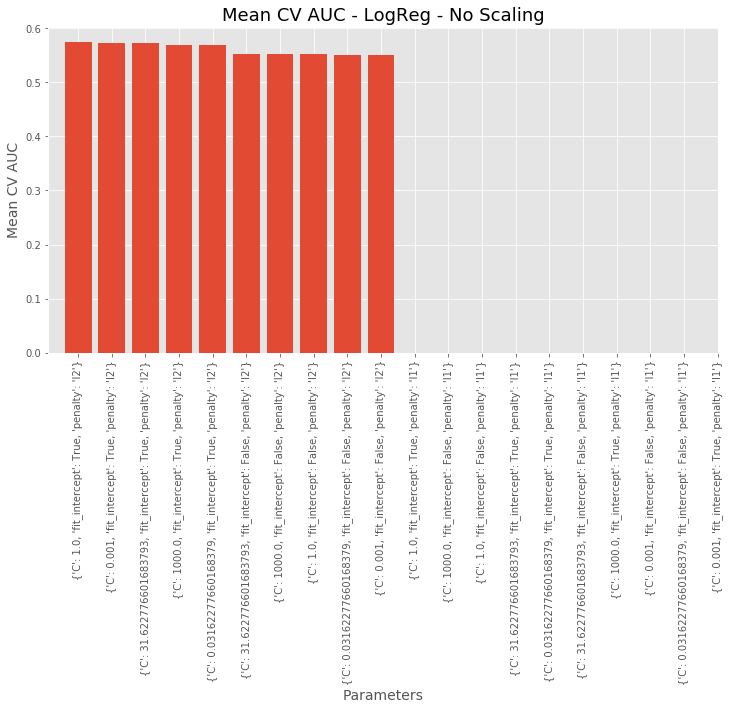

In [234]:
visualizeCVResults(logReg_CV_2, model_name='LogReg - No Scaling', metric='auc')

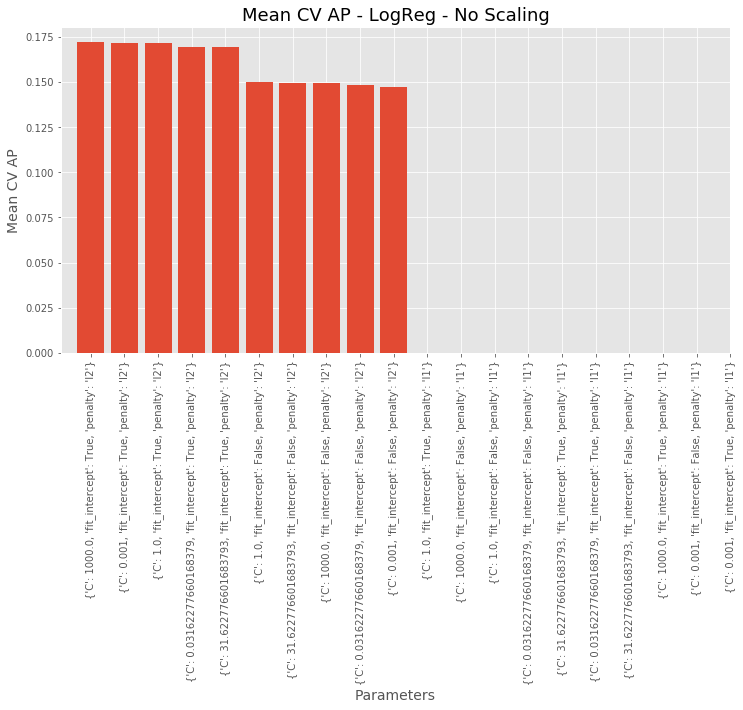

In [233]:
visualizeCVResults(logReg_CV_2, model_name='LogReg - No Scaling', metric='map')

## Training According to Zheng's Model

Using 5-fold cross validation with the training set to train a logistic regression model according to Zheng's parameters
1. Penalty: `L2`
2. Inverse of Regularization Coefficient: 1.0
3. Feature Scaling - Standard (by day - Zheng, by customer - us).

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [0]:
class Transposer(BaseEstimator, TransformerMixin):
  """Transposes a matrix of features"""
  def __init__(self):
    # Do nothing for now
    pass

  def fit(self, X, y=None):
    # Do nothing for now 
    return self

  def transform(self, X, y=None):
    return X.transpose()

In [0]:
myPipeline = Pipeline([
                       # First transpose to make kWhs of a single consumer into a new feature
                        ('Transposer', Transposer()), 
                       
                       # Then standardise the kWhs of every consumer as samples
                        ('FeatureScaler', MyFeatureScaler()), # No arg so standard scaler
                       
                       # After standardising, retranspose to make kWhs features rather than samples
                        ('Retransposer', Transposer())
])

In [0]:
zhengsPipeline = Pipeline([
                           ('FeatureScaler', MyFeatureScaler())
])

In [0]:
X_train_zheng = zhengsPipeline.fit_transform(X_train)
X_train_custom = myPipeline.fit_transform(X_train)

Text(0.5, 1.0, 'Feature Distribution - My Method')

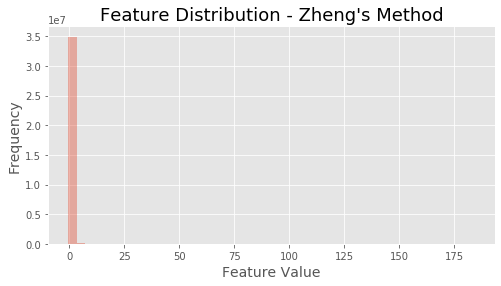

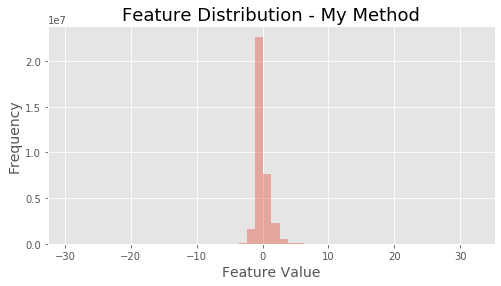

In [252]:
# Visualizing distributions of both pipelines 
plt.figure(figsize=(8, 4))
distplot(X_train_zheng.ravel(), kde=False)
plt.xlabel('Feature Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title("Feature Distribution - Zheng's Method", fontsize=18)

plt.figure(figsize=(8, 4))
distplot(X_train_custom.ravel(), kde=False)
plt.xlabel('Feature Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title("Feature Distribution - My Method", fontsize=18)

## Interpretation
- Zheng's method just stanardizes all kWhs on a single day across all consumers. This means standardisation is done by using the mean and standard deviation in kWhs of all consumers on a single day.
- My method implements Dr. Baig's intuition: it makes more sense to scale kWh values for a single consumer using that consumer's mean and standard deviation rather than the mean and standard deviation of all consumers on a single day.
- The distribution of values with Zheng's method goes all the way up to ~180, implying that there are lots of outliers. Also, the dataset looks very skewed. 
- My distribution is a nice, clean, normal distribution centered at 0 (albeit with a slightly larger standard deviation than 1?).

Going to use my values instead of Zheng's.

## Cross Validating Zheng's Model

In [0]:
# Initialise a new Logistic Regression estimator
logRegZheng = LogisticRegression(random_state=0, penalty='l2', C=1.0)

In [0]:
from sklearn.model_selection import cross_validate

In [0]:
skf_zheng = StratifiedKFold(n_splits=5, random_state=0)

In [274]:
zheng_logreg_scores = cross_validate(estimator=logRegZheng, 
                                     X=X_train_zheng, y=y_train, 
                                     cv=5, # Will automatically use stratified sampling
                                     scoring={ 'roc_auc_scorer': roc_auc_scorer, 
                                              'map_scorer': avg_precision_scorer,},
                                     n_jobs=-1,
                                     verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


In [292]:
for key, values in zheng_logreg_scores.items():
  print(f'Max {key}: {np.max(values)}')
  print(f'Average {key}: {np.max(values)}\n')

Max fit_time: 8.060572385787964
Average fit_time: 8.060572385787964

Max score_time: 0.04259490966796875
Average score_time: 0.04259490966796875

Max test_roc_auc_scorer: 0.5737224398872655
Average test_roc_auc_scorer: 0.5737224398872655

Max test_map_scorer: 0.3031418246705869
Average test_map_scorer: 0.3031418246705869



## Hyperparameter Tuning of My Model

In [0]:
logRegCustom = LogisticRegression(random_state=0)

In [0]:
param_grid = {
    'C': np.logspace(-3, 3, 5),     # Regularization coefficient - lower values = stronger regularization
    'penalty': ['l1', 'l2'],        # L1 norm or L2 norm for regularization
    'fit_intercept': [True, False], # Include bias term or not
}

In [0]:
# Instantiating a grid search object that will use both AUC and MAP 
logRegCustom_CV = GridSearchCV(
    logRegCustom,     
    param_grid, 
    cv=StratifiedKFold(n_splits=5, random_state=0),
    verbose=1,
    n_jobs=-1,
    scoring = {
        'roc_auc_scorer': roc_auc_scorer,
        'map_scorer': avg_precision_scorer,
    }, 
    refit='roc_auc_scorer',
)

In [297]:
logRegCustom_CV.fit(X_train_custom, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n...
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit='roc_auc_scorer

In [299]:
logRegCustom_CV.best_params_

{'C': 31.622776601683793, 'fit_intercept': False, 'penalty': 'l2'}

In [300]:
logRegCustom_CV.best_score_

0.5226322107944208

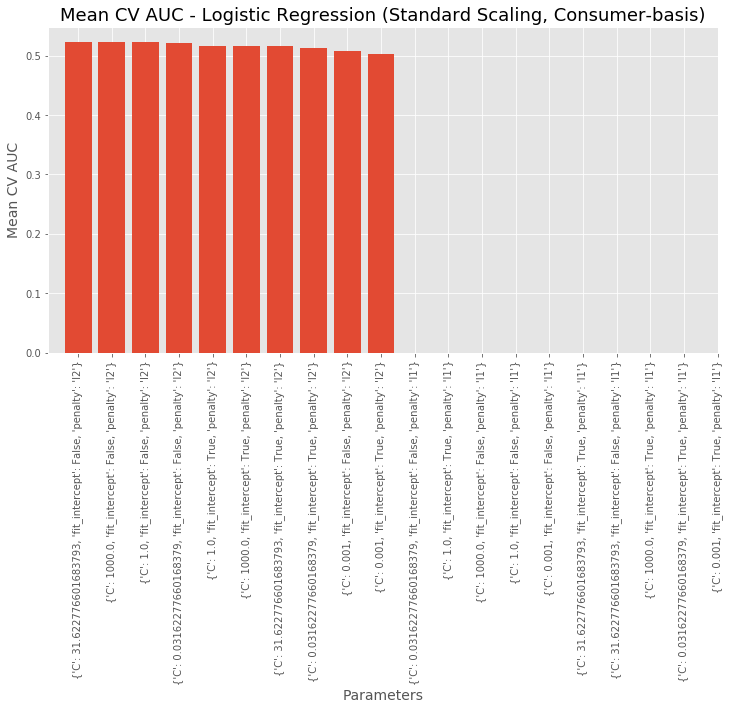

In [302]:
visualizeCVResults(logRegCustom_CV, model_name='Logistic Regression (Standard Scaling, Consumer-basis)', 
                   metric='auc')

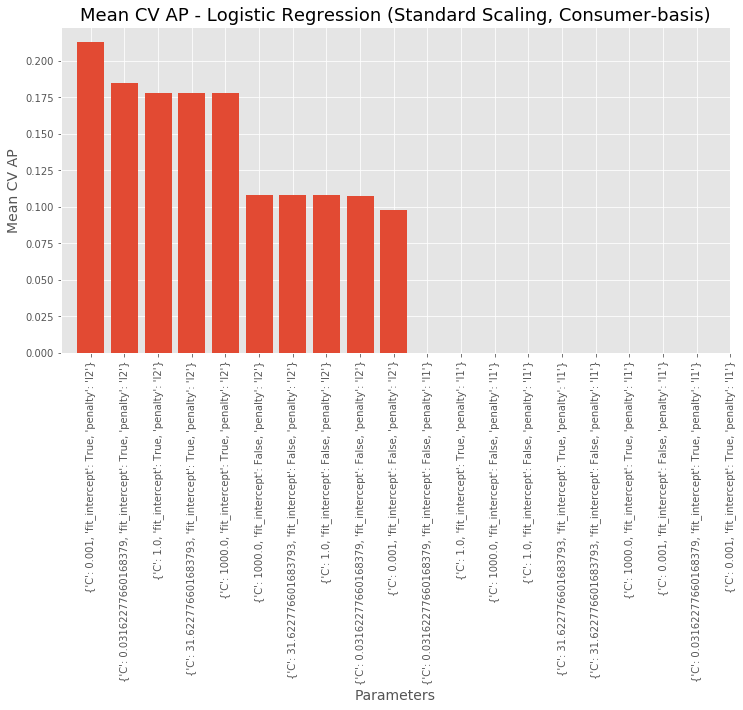

In [303]:
visualizeCVResults(logRegCustom_CV, model_name='Logistic Regression (Standard Scaling, Consumer-basis)', 
                   metric='map')

I am totally making a mistake.

In [0]:
logReg3 = LogisticRegression(C=1.0, random_state=0, penalty='l2')

In [309]:
logReg3_scores = cross_validate(estimator=logReg3, 
                                     X=X_train_custom, y=y_train, 
                                     cv=5, # Will automatically use stratified sampling
                                     scoring={ 'roc_auc_scorer': roc_auc_scorer, 
                                              'map_scorer': avg_precision_scorer,},
                                     n_jobs=-1,
                                     verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


In [310]:
for key, values in zheng_logreg_scores.items():
  print(f'Max {key}: {np.max(values)}')
  print(f'Average {key}: {np.max(values)}\n')

Max fit_time: 7.861364841461182
Average fit_time: 7.861364841461182

Max score_time: 0.05010986328125
Average score_time: 0.05010986328125

Max test_roc_auc_scorer: 0.5216561510058931
Average test_roc_auc_scorer: 0.5216561510058931

Max test_map_scorer: 0.19825391856575997
Average test_map_scorer: 0.19825391856575997

